<a href="https://colab.research.google.com/github/lovegolf54/book-recommender-system/blob/master/Ontology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install owlready2
!pip install -U pythainlp
!pip install -U emoji
!pip install deepcut
!pip install pickle
!pip install itertools

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


#1.Ontology Development - Ontology Integration



In [2]:
from owlready2 import *
import csv

# Sample CSV file paths
book_csv_file = "Booknew.csv"
course_csv_file = "Course.csv"

# Create the ontology
onto = get_ontology("http://example.com/ontology")

# Define the class hierarchy
class Book(Thing):
    namespace = onto

class Author(Thing):
    namespace = onto

class Label(Thing):
    namespace = onto

class Course(Thing):
    namespace = onto

# Define properties and relationships
class hasAuthor(ObjectProperty):
    domain = [Book]
    range = [Author]

class usedInCourse(ObjectProperty):
    domain = [Book]
    range = [Label]

class hasCourseNameThai(DataProperty, FunctionalProperty):
    domain = [Course]
    range = [str]

class hasCourseDescriptionThai(DataProperty, FunctionalProperty):
    domain = [Course]
    range = [str]

# Open the Book CSV file for reading
with open(book_csv_file, 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        # Read data from each row in the Book CSV file
        isbn = row['isbn']
        title = row['title']
        authors = row['author'].split(',')
        description = row['description']
        loc = row['loc']
        publisher = row['publisher']
        year = row['year']
        bal = row['bal']

        # Create book instance and assign properties
        book = Book(isbn)
        book.title = [title]
        book.description = [description]
        book.loc = [loc]
        book.publisher = [publisher]
        book.year = [year]

        # Create author instances and establish relationships
        author_objs = []
        for author in authors:
            author_obj = Author(author)
            author_objs.append(author_obj)

        if len(author_objs) > 0:
            with onto:
                book.hasAuthor = author_objs

        # Create label instance and establish relationship
        if bal:
            label_obj = Label(bal)
            with onto:
                book.usedInCourse = [label_obj]

# Open the Course CSV file for reading
with open(course_csv_file, 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        # Read data from each row in the Course CSV file
        course_id = row['Course_ID']
        course_name_thai = row['Course_name_thai']
        course_description_thai = row['Course_description_thai']

        # Create course instance and assign properties
        course = Course(course_id)
        course.hasCourseNameThai = [course_name_thai]
        course.hasCourseDescriptionThai = [course_description_thai]

# Save the updated ontology to a specific file path
onto.save(file="ontology.owl")

In [ ]:
# Load the ontology file
onto = get_ontology("ontology.owl").load()

# Get the classes
book_class = onto.Book
author_class = onto.Author

# Find all books and their authors
book_author_pairs = []
for book in book_class.instances():
    authors = book.hasAuthor
    for author in authors:
        book_author_pairs.append((book, author))

# Print the book-author relationships
for book, author in book_author_pairs:
    print("Book:", book.title[0])
    print("Author:", author.name)
    print("---")


In [4]:
!pip install rdflib

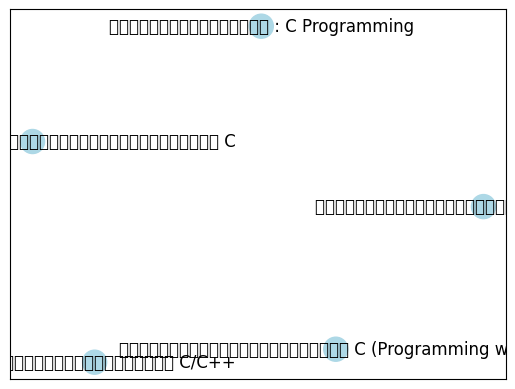

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the ontology file
onto = get_ontology("ontology.owl").load()

# Get the classes
book_class = onto.Book
author_class = onto.Author

# Create an empty graph
G = nx.Graph()

# Find all books and their authors
book_author_pairs = []
for book in book_class.instances():
    authors = book.hasAuthor
    for author in authors:
        book_author_pairs.append((book, author))

# Add nodes and edges to the graph
for book, author in book_author_pairs:
    book_title = book.title[0]
    author_name = author.name
    G.add_node(book_title, node_type='book')
    G.add_node(author_name, node_type='author')
    G.add_edge(book_title, author_name)

# Filter the graph to include only the first five books
book_titles = [book.title[0] for book, _ in book_author_pairs[:5]]
G_filtered = G.subgraph(book_titles)

# Define node colors based on node type
node_colors = {'book': 'lightblue', 'author': 'lightgreen'}
colors = [node_colors[G_filtered.nodes[node]['node_type']] for node in G_filtered.nodes]

# Draw the graph
pos = nx.spring_layout(G_filtered)
nx.draw_networkx(G_filtered, pos, node_color=colors, with_labels=True)

# Show the graph
plt.show()

#2.Semantic Annotation

#3.Enhanced Feature Extraction

In [8]:
import nltk
import string
nltk.download('stopwords')

from pythainlp.util import normalize
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from nltk.corpus import stopwords

from pythainlp.tokenize import sent_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import re
import pythainlp

df = pd.read_csv('csv_file').drop_duplicates()
df = df.astype(str)

FileNotFoundError: ignored

In [ ]:
def clean_text(text):
    text = normalize(text)
    text = text.lower()
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    text = text.replace('“', '')
    text = text.replace('”', '')
    text = text.replace('…', '')
    text = text.replace('\xa0', '')
    text = re.sub('['+string.punctuation+']', ' ', text)
    return text

In [ ]:
def tokennize(text, stop_words, thaistopwords):
    tokens = word_tokenize(text, keep_whitespace=False, engine="newmm")
    tokens = set(tokens) - stop_words - thaistopwords
    return tokens

In [ ]:
df['tokens'] = df['isbn'] + df['title'] + df['description'] + df['loc'] + df['author'] + df['publisher'] + df['year'] + df['bal']
df['tokens'] = df['tokens'].apply(clean_text)

In [ ]:
thaistopwords = set(thai_stopwords())
stop_words = set(stopwords.words('english'))

In [ ]:
df['tokens'] = df['tokens'].apply(lambda x: tokennize(x, stop_words, thaistopwords))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pythainlp.ulmfit import process_thai
from sklearn.pipeline import Pipeline
import emoji

In [ ]:
def identity_fun(text):
    return text

In [ ]:
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', #this is default
                                   tokenizer=identity_fun, #does no extra tokenizing
                                   preprocessor=identity_fun, #no extra preprocessor
                                   token_pattern=None,)

tfidf_vector= tfidf_vectorizer.fit_transform(df['tokens'])
tfidf_array = np.array(tfidf_vector.todense())

df_tfidf = pd.DataFrame(tfidf_array,columns=tfidf_vectorizer.get_feature_names_out())

#4.Training and Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=100)
selected_features = selector.fit_transform(tfidf_vector, df['bal'])

# แสดงจำนวนคุณลักษณะที่เลือก
num_selected_features = selected_features.shape[1]
print("Number of selected features:", num_selected_features)

# แสดงค่า p-value ของคุณลักษณะที่ถูกเลือก
feature_scores = -np.log10(selector.pvalues_)
print("Feature scores (p-values):", feature_scores)

# แสดงรายชื่อคุณลักษณะที่ถูกเลือก
feature_names = tfidf_vectorizer.get_feature_names_out()
selected_feature_names = [feature_names[i] for i in selector.get_support(indices=True)]
print("Selected feature names:", selected_feature_names)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.stats import randint
import pickle

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['bal'], test_size=0.3, random_state=42)

# Define the parameter grid for Randomized Search
param_grid = {
    'n_estimators': randint(10, 100),
    'max_depth': [None] + list(range(5, 20)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Define the model
model = RandomForestClassifier(random_state=2)

# Perform Randomized Search to find the best hyperparameters
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3)
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:")
print(random_search.best_params_)

# Use the best model obtained from Randomized Search
best_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model
model_filename = "book_recommendation_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(best_model, file)
print(f"Trained model saved as '{model_filename}'")
